# Assignment

We will be comparing decision trees and random forests by using [Healthcare Dataset Stroke Data](https://www.kaggle.com/asaumya/healthcare-dataset-stroke-data#train_2v.csv) from Kaggle to predict if a patient has had a stroke. 

In [21]:
# Libraries 
import numpy as np
import pandas as pd

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Evaluation 
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Random Forests 
from sklearn import ensemble

# Feature Selection 
from sklearn.decomposition import PCA

In [2]:
# Import data

test = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/test_2v.csv')
train = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/train_2v.csv')

In [3]:
train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')
train.head()

id  gender   age  hypertension  heart_disease ever_married  \
0  30669    Male   3.0             0              0           No   
1  30468    Male  58.0             1              0          Yes   
2  16523  Female   8.0             0              0           No   
3  56543  Female  70.0             0              0          Yes   
4  46136    Male  14.0             0              0           No   

      work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0      children          Rural              95.12  18.0              NaN   
1       Private          Urban              87.96  39.2     never smoked   
2       Private          Urban             110.89  17.6              NaN   
3       Private          Rural              69.04  35.9  formerly smoked   
4  Never_worked          Rural             161.28  19.1              NaN   

   stroke  
0       0  
1       0  
2       0  
3       0  
4       0

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


This dataset has 12 attributes containing patien information. Currently, there are 7 numeric and 5 categorical variables. 

We will continue by cleaning the dataset before modeling. 

## Data cleaning 
Let's start by checking for null values. 

In [5]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
# Check for missing values 

missing_values_table(train)

Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values
smoking_status           13292               30.6
bmi                       1462                3.4

It looks like there are a couple of missing values in columns like and share. We'll fill in those missing values with the mode. 

In [7]:
# Imputation by mode
df2 = train.copy()

df2 = train.fillna(train.mode().iloc[0])

In [8]:
missing_values_table(df2)

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

There doesn't appear to be apparent missing values. We're ready to start exploring the data. 

First, let's see if the outcome variable is relatively balanced. 

In [9]:
#Make sure the classes are balanced

df2['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

The numbers represent 0 for no stroke and 1 for stroke. These classes are highly imbalanced. There are substantially more patients who have not suffered from a stroke. This poses a challenge when working with decision trees since they tend to predict the majority class data. There is a high probability of misclassifying the minority class since the algorithm treat minority class features as noise. We will handle the class imbalance with bagging.

Let's drop the id column since that will not help the model predict which patient has suffered from a stroke. 

In [10]:
# Drop ID column 

df2 = df2.drop(['id'], axis=1)

In [11]:
# exclude the response
feature_cols = df2.columns
feature_cols = feature_cols.drop('stroke')

In [12]:
#Set up the predictors and the target variable. 
#Get dummies for the categorical variables.
X = df2[feature_cols]
X = pd.get_dummies(X)
Y = df2['stroke']

## Decision Tree
Now that we have a clean feature set, we're ready to try a decision tree classifier to predict whether patients have suffered from a stroke or not.

### Iteration 1

In [22]:
#Track runtime.
start_time = time.time()

#Initialize model. The dataset is small, so max_features is set to None.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=None,
    max_depth=None,
)
decision_tree.fit(X, Y)

#Cross-validate using 10 folds.
score = cross_val_score(decision_tree, X, Y, cv=10)

print("--- %s seconds ---" % (time.time() - start_time))
print(score)
print(score.mean())
print(score.var())

--- 1.9954228401184082 seconds ---
[0.96406358 0.9615296  0.96245105 0.9624424  0.9656682  0.96129032
 0.96635945 0.96335561 0.9684259  0.96335561]
0.9638941726474407
4.6931643899484555e-06


This decision tree model preformed fairly well with an accuracy rate of 96%. It doesn't appear that the model is overfitted since the score across 10 folds are around 96%. 

In [25]:
import graphviz
# Render Tree
dt_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=str(Y.unique()))
graph = pydotplus.graph_from_dot_data(dt_data)
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.525121 to fit



We did not select a max depth which causes the numerous decision trees to form. Let's try sitting a max depth at 5 and see what happens. 

### Iteration 2

In [29]:
#Track runtime.
start_time = time.time()

#Initialize model. The dataset is small, so max_features is set to None.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=None,
    max_depth=5,
)
decision_tree.fit(X, Y)

#Cross-validate using 10 folds.
score = cross_val_score(decision_tree, X, Y, cv=10)

print("--- %s seconds ---" % (time.time() - start_time))
print(score)
print(score.mean())
print(score.var())

--- 1.0856602191925049 seconds ---
[0.98180143 0.98157107 0.98180143 0.98179724 0.98202765 0.98179724
 0.98179724 0.98179304 0.98202351 0.98179304]
0.9818202865360461
1.5019909848441976e-08


By limiting the max depth to 5, we increased the accuracy score to 98%. 

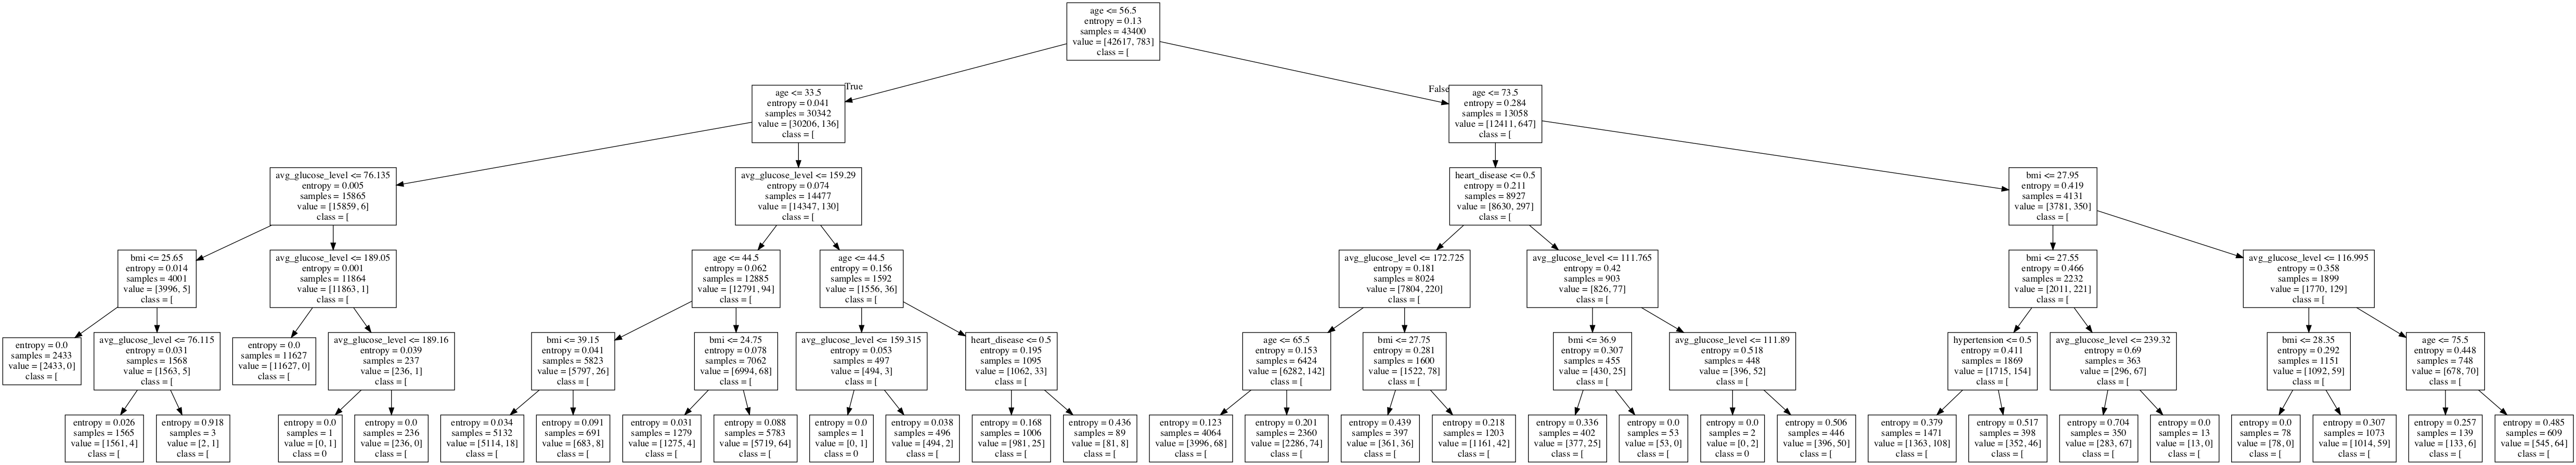

In [30]:
import graphviz
# Render Tree
dt_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=str(Y.unique()))
graph = pydotplus.graph_from_dot_data(dt_data)
Image(graph.create_png())

## Random Forest
### Iteration 1

In [23]:
#Track runtime.
start_time = time.time()

rfc = ensemble.RandomForestClassifier(
    criterion='gini',
    max_features='log2',
    max_depth=None,
    n_estimators=150)

rfc.fit(X, Y)

score = cross_val_score(rfc, X, Y, cv=10)

print("--- %s seconds ---" % (time.time() - start_time))
print(score)
print(score.mean())
print(score.var())

--- 55.36269783973694 seconds ---
[0.9813407  0.98087998 0.98157107 0.98202765 0.98202765 0.98179724
 0.98179724 0.98202351 0.9813321  0.98156257]
0.9816359706550889
1.2696585237381106e-07


The first iteration of the random forest model peforms better than the first iteration of the decision model. The accurary score of this random forest model is around 98% which is comparable to the second iteration of the decision model after setting the max depth to 5. Let's try setting the max depth to 5 and see hat happens. 

In [31]:
#Track runtime.
start_time = time.time()

rfc = ensemble.RandomForestClassifier(
    criterion='gini',
    max_features='log2',
    max_depth=5,
    n_estimators=150)

rfc.fit(X, Y)

score = cross_val_score(rfc, X, Y, cv=10)

print("--- %s seconds ---" % (time.time() - start_time))
print(score)
print(score.mean())
print(score.var())

--- 50.08381175994873 seconds ---
[0.98180143 0.98180143 0.98180143 0.98202765 0.98202765 0.98202765
 0.98202765 0.98202351 0.98202351 0.98202351]
0.981958540696738
1.0581936837650791e-08


The random forest model ran 5 seconds faster than the first iteration without a set max depth. The accuracy score remained around 98%.

## Conclusion

Decision trees and random forests are good fits for this dataset. Although random forests was able to predict with a higher accuracy score than decision trees without set parameters, it took substantially longer to load than a decision tree. 